In [1]:
import sys
import requests
import re
import numpy as np
from scipy.special import erfinv
import matplotlib.pyplot as plt
import csv
from IPython.display import clear_output

key='ozyravmBN53mCh2imk7RmocE68QfSfjjuERYiFsqtB2j3mRog4YOoNfk4nq7t7UC'
login={'X-TBA-Auth-Key':key}

def qual_points(R,N,a=1.07):
    return np.ceil(erfinv((N-2*R+2)/(a*N))*10/erfinv(1/a)+12)
def pick_points(alliance,pick):
    if(alliance==None): return 0
    elif(pick==2): return alliance
    else: return 17-alliance
def score(rank,compnum,awards,c_rank,c_awards,chair,ei):
    return 22*(1-rank)*compnum+20*awards+22*(1-c_rank)+30*c_awards+60*chair+45*ei
def find(team,team_list):
    team='frc'+str(team)
    for i in range(len(team_list)):
        if (team_list[i][0]==team): return i
    return None
def update_progress(progress):
    barLength = 50 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

# Regionals

In [5]:
event_name='2019cada'
teams_list=requests.get('https://www.thebluealliance.com/api/v3/event/'+event_name+'/teams/keys',params=login)
teams=teams_list.json()

In [6]:
team_scores=[]
rookies=0
update_progress(0)
for t in teams:
    team_no=int(re.findall(r'\d+',t)[0])
    if(team_no<7400):
        metrics=[[[],[],[]],[[],[],[]],[[],[],[]]]
        for y in ['2018','2017','2016']:#'2018','2017',
            event_keys=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/keys',params=login)
            r=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/statuses',params=login)
            keys=event_keys.json()
            data=r.json()
            for k in keys:
                if(data[k]!=None):
                    if(data[k]['qual']!=None):
                        event=requests.get('https://www.thebluealliance.com/api/v3/event/'+k+'/simple',params=login)
                        awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                        if((event.json()['event_type']==1)or(event.json()['event_type']==0)):#regionals and districts
                            score=qual_points(data[k]['qual']['ranking']['rank'],data[k]['qual']['num_teams'])
                            if(data[k]['alliance']!=None):
                                score+=pick_points(data[k]['alliance']['number'],data[k]['alliance']['pick'])+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    score+=60
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=20
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=5
                            metrics[2018-int(y)][0].append(score)
                        elif(event.json()['event_type']==3):#champs divisions
                            score=qual_points(data[k]['qual']['ranking']['rank'],data[k]['qual']['num_teams'])
                            if(data[k]['alliance']!=None):
                                score+=pick_points(data[k]['alliance']['number'],data[k]['alliance']['pick'])+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    score+=110
                                if(awards[i]['award_type']==69):#chairman's finalist
                                    score+=90
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=30
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=10
                            metrics[2018-int(y)][1].append(score)
                    elif(data[k]['playoff']!=None):
                        event=requests.get('https://www.thebluealliance.com/api/v3/event/'+k+'/simple',params=login)
                        awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                        if(event.json()['event_type']==4):#einstein
                            score=5+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    score+=110
                                if(awards[i]['award_type']==69):#chairman's finalist
                                    score+=90
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=30
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=10
                            metrics[2018-int(y)][2].append(score)
        mean=np.zeros(3)
        std=np.zeros(3)
        for i in range(3):
            if(len(metrics[0][i])+len(metrics[1][i])+len(metrics[2][i])==0):
                mean[i]=0
            else:
                mean[i]=(sum(metrics[0][i])+sum(metrics[1][i])/2+sum(metrics[2][i])/3)/(len(metrics[0][i])+len(metrics[1][i])/2+len(metrics[2][i])/3)
            if(metrics[0][i]+metrics[1][i]+metrics[2][i]==None):
                std[i]=0
            else:
                std[i]=np.std(metrics[0][i]+metrics[1][i]+metrics[2][i])
        team_scores.append([team_no,round(mean[0]-std[0],1),round(mean[1]-std[1],1),round(mean[2]-std[2],1)])
    else:
        rookies+=1
    update_progress((teams.index(t)+1)/len(teams))
if(rookies>0): team_scores.append(['Rookie',round((40/rookies+13+236/len(teams))-19.2,1),0,0])#40pts from rookie awards,13 avg ranking points,236 picking points
team_scores.sort(key=lambda score: score[1], reverse=True)
if(rookies>0): ind=team_scores.index(['Rookie',round((40/rookies+13+236/len(teams))-19.2,1),0,0])+1
else: ind=int(np.floor(len(teams)/2))

filename=event_name+'.csv'
with open(filename,'a',newline='') as csv_file:
    writer=csv.writer(csv_file)
    for i in range(len(team_scores)):
        writer.writerow(team_scores[i])
        
clear_output()
print(str(ind+rookies)+': '+str(rookies)+' Rookies')
print(team_scores[0:ind])#

56: 5 Rookies
[[1678, 77.9, 69.2, 19.0], [1323, 57.2, 64.5, 15.0], [973, 53.9, 29.9, 30.0], [1056, 36.8, nan, nan], [701, 35.7, 17.8, nan], [2141, 29.8, nan, nan], [6918, 27.0, nan, nan], [3250, 26.8, 29.0, nan], [3880, 26.7, 9.2, nan], [114, 26.5, 12.0, nan], [6474, 24.5, 9.2, nan], [1072, 21.8, 39.0, 15.0], [3970, 21.3, 16.2, nan], [4904, 21.2, 26.0, nan], [6883, 20.0, nan, nan], [4135, 19.7, 8.7, nan], [5507, 17.2, nan, nan], [5496, 17.0, 13.7, nan], [3482, 16.0, nan, nan], [2839, 15.3, 11.0, nan], [5940, 14.4, 19.0, nan], [7229, 14.0, nan, nan], [2551, 12.9, nan, nan], [199, 12.5, 11.0, nan], [5458, 12.4, 31.3, nan], [4698, 11.2, 11.0, nan], [2367, 10.8, 30.0, nan], [6644, 10.8, nan, nan], [5480, 10.5, nan, nan], [7137, 10.0, 10.0, nan], [3598, 9.8, 11.0, nan], [2085, 9.7, nan, nan], [6657, 9.2, nan, nan], [5419, 9.0, nan, nan], [6174, 8.3, nan, nan], [3189, 8.1, 3.0, nan], [6238, 8.0, nan, nan], [6926, 8.0, nan, nan], [6305, 7.1, 7.0, nan], [2204, 7.0, nan, nan], [6981, 7.0, nan, 

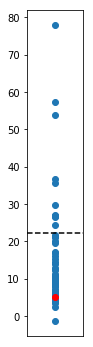

In [7]:
x=[0] *len(team_scores)
y=[x[1] for x in team_scores]

tot_score=236+85+60+45+25+15+20*5+10+9*5
for i in range(1,len(teams)+1):
    tot_score+=qual_points(i,len(teams))

fig1=plt.figure(figsize=[1,6])
ax1=plt.axes()
ax1.axes.get_xaxis().set_visible(False)
plt.axhline(y=tot_score/len(teams),c='black',linestyle='--')
plt.scatter(x,y)
plt.scatter(0,y[ind],c='red')

# Districts

In [9]:
event_name='2019pch'
teams_list=requests.get('https://www.thebluealliance.com/api/v3/district/'+event_name+'/teams/keys',params=login)
teams=teams_list.json()

In [10]:
#Need to think some more about rookie score, not sure it's 100% right. Also need to think about if need to consider the fact that we only get points for the first 2 events a team plays at
team_scores=[]
rookies=0
update_progress(0)
for t in teams:
    team_no=int(re.findall(r'\d+',t)[0])
    if(team_no<7400):
        metrics=[[[],[],[]],[[],[],[]],[[],[],[]]]
        for y in ['2018','2017','2016']:#'2018','2017',
            event_keys=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/keys',params=login)
            r=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/statuses',params=login)
            keys=event_keys.json()
            data=r.json()
            for k in keys:
                if(data[k]!=None):
                    if(data[k]['qual']!=None):
                        event=requests.get('https://www.thebluealliance.com/api/v3/event/'+k+'/simple',params=login)
                        awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                        if((event.json()['event_type']==1)or(event.json()['event_type']==0)):#regionals and districts
                            score=qual_points(data[k]['qual']['ranking']['rank'],data[k]['qual']['num_teams'])
                            if(data[k]['alliance']!=None):
                                score+=pick_points(data[k]['alliance']['number'],data[k]['alliance']['pick'])+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    score+=60
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=20
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=5
                            metrics[2018-int(y)][0].append(score)
                        elif(event.json()['event_type']==3):#champs divisions
                            score=qual_points(data[k]['qual']['ranking']['rank'],data[k]['qual']['num_teams'])
                            if(data[k]['alliance']!=None):
                                score+=pick_points(data[k]['alliance']['number'],data[k]['alliance']['pick'])+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    score+=110
                                if(awards[i]['award_type']==69):#chairman's finalist
                                    score+=90
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=30
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=10
                            metrics[2018-int(y)][1].append(score)
                    elif(data[k]['playoff']!=None):
                        event=requests.get('https://www.thebluealliance.com/api/v3/event/'+k+'/simple',params=login)
                        awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                        if(event.json()['event_type']==4):#einstein
                            score=5+5*data[k]['playoff']['record']['wins']
                            for i in range(len(awards)):
                                if(awards[i]['award_type']==0):#chairman's
                                    score+=110
                                if(awards[i]['award_type']==69):#chairman's finalist
                                    score+=90
                                if(awards[i]['award_type']==9):#engineering inspiration
                                    score+=45
                                if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                    score+=30
                                if any([awards[i]['award_type'] in [22,11,27,13,18,30]]):#others
                                    score+=10
                            metrics[2018-int(y)][2].append(score)
        mean=np.zeros(3)
        std=np.zeros(3)
        for i in range(3):
            if(len(metrics[0][i])+len(metrics[1][i])+len(metrics[2][i])==0):
                mean[i]=0
            else:
                mean[i]=(sum(metrics[0][i])+sum(metrics[1][i])/2+sum(metrics[2][i])/3)/(len(metrics[0][i])+len(metrics[1][i])/2+len(metrics[2][i])/3)
            if(metrics[0][i]+metrics[1][i]+metrics[2][i]==None):
                std[i]=0
            else:
                std[i]=np.std(metrics[0][i]+metrics[1][i]+metrics[2][i])
        team_scores.append([team_no,round(mean[0]-std[0],1),round(mean[1]-std[1],1),round(mean[2]-std[2],1)])
    else:
        rookies+=1
    update_progress((teams.index(t)+1)/len(teams))
if(rookies>0):
    num_events=len(requests.get('https://www.thebluealliance.com/api/v3//district/'+event_name+'/events/simple',params=login).json())
    team_scores.append(['Rookie',round((40*num_events/rookies+13+236*num_events/len(teams))-19.2,1),0,0]) #40pts from rookie awards,13 avg ranking points,236 picking points
team_scores.sort(key=lambda score: score[1], reverse=True)
if(rookies>0): ind=team_scores.index(['Rookie',round((40*num_events/rookies+13+236*num_events/len(teams))-19.2,1),0,0])+1
else: ind=int(np.floor(len(teams)/2))

filename=event_name+'.csv'
with open(filename,'a',newline='') as csv_file:
    writer=csv.writer(csv_file)
    for i in range(len(team_scores)):
        writer.writerow(team_scores[i])
        
clear_output()
print(str(ind+rookies)+': '+str(rookies)+' Rookies')
print(team_scores[0:ind])#

84: 10 Rookies
[[2974, 64.3, 25.0, nan], [4188, 63.0, 15.8, 25.0], [1746, 61.6, 27.1, nan], [4910, 60.1, 9.9, 20.0], [6705, 57.5, 11.5, nan], [1648, 54.2, 13.3, nan], [4026, 46.2, 11.0, nan], [1311, 38.8, 8.0, nan], [4941, 37.1, 14.8, nan], [2415, 35.6, 20.1, 15.0], [832, 35.3, 5.0, nan], [4468, 33.6, 14.0, nan], [7104, 32.0, nan, nan], [4189, 29.0, 13.0, nan], [6340, 28.7, 30.0, nan], [6829, 27.9, nan, nan], [1102, 27.6, 25.0, nan], [3581, 27.5, nan, nan], [3998, 25.5, nan, nan], [1771, 24.7, nan, nan], [1683, 24.5, nan, nan], [7315, 24.0, nan, nan], [5332, 22.0, 8.0, nan], [6919, 22.0, 12.0, nan], [3635, 21.7, 13.0, nan], [6177, 21.5, nan, nan], [1002, 21.3, 9.8, nan], [6471, 20.5, nan, nan], [5109, 19.5, 12.0, nan], [5482, 19.4, nan, nan], [4112, 17.9, 56.0, 15.0], [3815, 17.1, nan, nan], [6341, 17.1, nan, nan], [6023, 16.2, 12.0, nan], [5900, 15.2, 6.0, nan], [5293, 14.4, 16.0, nan], [4516, 13.9, 38.0, nan], [1261, 13.7, 10.8, nan], [5608, 13.7, nan, nan], [6325, 13.6, 12.0, nan], 

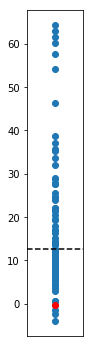

In [11]:
x=[0] *len(team_scores)
y=[x[1] for x in team_scores]

#not accurate average score for all events, need to try something like:
tot_score=(468+236+85+60+45+25+15+20*5+10+9*5)*num_events #ranking points for 36team event,pick points,elim win points,chairmans,EI,RAS,RI,robot,WFFA,others

#tot_score=236+85+60+45+25+15+20*5+10+9*5#pick points,elim win points,chairmans,EI,RAS,RI,robot,WFFA,others
#for i in range(1,len(teams)+1):
    #tot_score+=qual_points(i,len(teams))

fig1=plt.figure(figsize=[1,6])
ax1=plt.axes()
ax1.axes.get_xaxis().set_visible(False)
plt.axhline(y=tot_score/len(teams),c='black',linestyle='--')
plt.scatter(x,y)
plt.scatter(0,y[ind],c='red')

In [95]:
score_list=[]
score=0
for t in range(6800,7332):
    t='frc'+str(t)
    y='2018'
    keys=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/keys',params=login).json()
    data=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/events/'+y+'/statuses',params=login).json()
    if('Errors' not in data):
        for k in keys:
            if(data[k]!=None):
                if(data[k]['qual']!=None):
                    event=requests.get('https://www.thebluealliance.com/api/v3/event/'+k+'/simple',params=login).json()
                    awards=requests.get('https://www.thebluealliance.com/api/v3/team/'+t+'/event/'+k+'/awards',params=login).json()
                    if((event['event_type']==1)or(event['event_type']==0)):#regionals and districts
                        score=qual_points(data[k]['qual']['ranking']['rank'],data[k]['qual']['num_teams'])
                        if(data[k]['alliance']!=None):
                            score+=pick_points(data[k]['alliance']['number'],data[k]['alliance']['pick'])+5*data[k]['playoff']['record']['wins']
                        for i in range(len(awards)):
                            if(awards[i]['award_type']==0):#chairman's
                                score+=60
                            if(awards[i]['award_type']==9):#engineering inspiration
                                score+=45
                            if(awards[i]['award_type']==10):#Rookie All Star
                                score+=25
                            if(awards[i]['award_type']==15):#Rookie Inspiration
                                score+=15
                            if any([awards[i]['award_type'] in [16,17,20,21,29,71]]):#robot awards
                                score+=20
                            if any([awards[i]['award_type'] in [22,11,27,13,14,18,30]]):#others: 14 is highest rookie seed
                                score+=5
                        score_list.append(score)
mean=np.mean(score_list)
std=np.std(score_list)

print(mean,std)

26.60282574568289 18.530068691300883
